# Intro
I'll be working again with the Gutenberg corpus from NLTK, but this time focusing on works of ten different authors from what we've looked at previously. We'll first clean and vectorize the data. Then, we'll aim to create clusters and compare those to the known labels of author name. Lastly, we'll try various supervised modeling methods and see which produces the best results in predicting the author of a given passage from our corpus.

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import re
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import gutenberg, stopwords
import string

%matplotlib inline

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
# Reading in the data
# Note that I'm taking a subset of a few of these to lessen the class imbalance
bible = gutenberg.paras(['bible-kjv.txt'])[0:5000]
blake = gutenberg.paras(['blake-poems.txt'])
bryant = gutenberg.paras(['bryant-stories.txt'])
burgess = gutenberg.paras(['burgess-busterbrown.txt'])
chesterton = gutenberg.paras(['chesterton-ball.txt'])
edgeworth = gutenberg.paras(['edgeworth-parents.txt'])[0:2000]
melville = gutenberg.paras(['melville-moby_dick.txt'])[0:1500]
milton = gutenberg.paras(['milton-paradise.txt'])
shakespeare = gutenberg.paras(['shakespeare-macbeth.txt'])
whitman = gutenberg.paras(['whitman-leaves.txt'])

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub("[``\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [5]:
authors = [bible,blake,bryant,burgess,chesterton,edgeworth,melville,milton,shakespeare,whitman]
author_names = ['bible','blake','bryant','burgess','chesterton','edgeworth','melville','milton','shakespeare','whitman']

In [6]:
# Cleaning the authors paragraphs
clean = []
author_column = []
author_counter = 0
punctuation_to_remove = re.sub("'", '', string.punctuation) + string.digits

# Cleaning the paragraphs
for author in authors:
    author_paras=[]
    for para in author:
        # create a running list with author name that's the length of number of paragraphs
        #author_column.append([author_names[author_counter]]*len(author))
        for item in para:
            clean_words=[]
            for word in item:
                # Text cleaner
                clean_word = text_cleaner(word)
                # Strip punctuation and numbers
                clean_word = ''.join([char for char in clean_word if char not in punctuation_to_remove])
                # make all lowercase
                clean_word = clean_word.lower()
                # add this to clean words
                clean_words.append(clean_word)
            # add these clean words to clean items
            clean_items = ' '.join(clean_words).replace(" ' ", "'")
            # remove extra whitespace
            clean_items = ' '.join(clean_items.split())
            author_paras.append(clean_items)
    author_column += ([author_names[author_counter]]*len(author_paras))
    author_counter += 1
    clean+=author_paras

In [7]:
# Creating a version that just has token lemmas, should we choose to use it later
import spacy
nlp = spacy.load('en')

In [8]:
fiction_clean_lemmas = []
for paragraph in clean:
    new_para = ''
    nlp_para = nlp(paragraph)
    for token in nlp_para:
        if not token.is_stop:
            new_para += token.lemma_ + ' '
    fiction_clean_lemmas.append(new_para)

In [25]:
len(author_paras)

4250

In [26]:
clean[-1000:]

["o thou transcendent nameless the fibre and the breath light of the light shedding forth universes thou centre of them thou mightier centre of the true the good the loving thou moral spiritual fountain affection's source thou reservoir o pensive soul of me o thirst unsatisfied waitest not there",
 'waitest not haply for us somewhere there the comrade perfect',
 'thou pulse thou motive of the stars suns systems that circling move in order safe harmonious athwart the shapeless vastnesses of space how should i think how breathe a single breath how speak if out of myself i could not launch to those superior universes',
 'swiftly i shrivel at the thought of god at nature and its wonders time and space and death but that i turning call to thee o soul thou actual me and lo thou gently masterest the orbs thou matest time smilest content at death and fillest swellest full the vastnesses of space',
 'greater than stars or suns bounding o soul thou journeyest forth what love than thine and ours 

Looks pretty clean to me! This should be good to start working with.

In [27]:
# Adding it all to a dataframe
literature_lemmas = pd.DataFrame({'author':author_column,'text':clean})
literature_lemmas.to_pickle("literature_lemmas.pkl")

# Adding the lemma version to a dataframe
literature_lemmas_lemmas = pd.DataFrame({'author':author_column,'text':fiction_clean_lemmas})
literature_lemmas_lemmas.to_pickle("literature_lemmas_lemmas.pkl")

__Start from here going forward to skip data import and cleaning...__

In [ ]:
literature_lemmas = pd.read_pickle("literature_lemmas.pkl")

In [28]:
literature_lemmas['author'].value_counts()

bible          5606
melville       5533
edgeworth      5384
chesterton     4779
whitman        4250
bryant         2863
shakespeare    1907
milton         1851
burgess        1054
blake           438
Name: author, dtype: int64

There is still some class imbalance, but we'll consider that acceptable. The next step is to reserve a portion of the data to use as a test set and begin vectorizing our paragraphs.

# Vectorization

In [26]:
X = literature_lemmas['text']
Y = literature_lemmas['author']

In [27]:
# Reserving 25% as a training set
from sklearn.model_selection import train_test_split

X = literature_lemmas['text']
Y = literature_lemmas['author']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=11)

In [28]:
# tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)
print(X_train_tfidf.shape)

(25248, 5947)


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


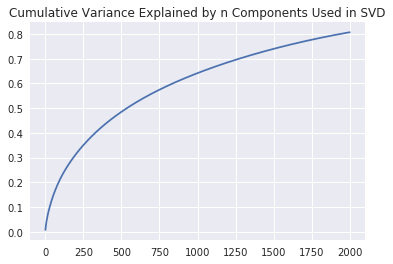

In [29]:
# LSA to reduce dimensionality to something more reasonable
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(2000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
cum_variance = np.cumsum(variance_explained)

plt.plot(np.arange(1,2001),cum_variance)
plt.title("Cumulative Variance Explained by n Components Used in SVD")
plt.show()

In [31]:
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

Let's arbitrarily use 100 features. I'm running this on an EC2 instance, so I think performance will hold up, but it's worth noting that we're missing a lot of variance by limiting this in such a way.

# Clustering

The next step is to get into some clustering! Even though clustering is an unsupervised method, we are lucky in that we have some output labels (author) to which to compare the clusters we're producing. We'll use the adjusted rand score (ARI) to compare the author categorization to the clusters we create. In other words, we're trying to create clusters that reproduce the authors.

### K-means

In [32]:
from sklearn.cluster import KMeans

Y_pred = KMeans(n_clusters=10, random_state=11).fit_predict(X_train_lsa)

In [33]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0          0     1    2    3     4    5    6    7    8     9
row_0                                                           
bible         13   155  134    7   628  154  644  840  177  1381
blake         17    96    4   24   127    3   25    7   10     3
bryant        64   293  212  386   957   80    7   19  135     9
burgess       10    78   20  135   517    1    0    0   30     0
chesterton   238   695  378   89  1801  243    4   28  144    12
edgeworth     79   384  382  156  2608   89    3   66  218    91
melville     245   968  122  105  2218  225   62   26  138    22
milton        45   586   16    0   312   65  256   71   33    19
shakespeare   26   139    5    6  1015   28   72   36   43    45
whitman       63  1171   12   32  1408  150  153   77  100    23


In [34]:
from sklearn import metrics

metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.053804627544117356

Our ARI score, along with a quick look at the crosstab, indicates that our clusters are not that different from a random selection, and certainly far from accurately grouping the different authors' works. Let's try a couple other methods.

### Spectral Clustering
I suspect this may work better given that, like k-means, the number of clusters can be defined while still allowing for non-globular geometry, unlike k-means.

In [35]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=10)
Y_pred = sc.fit_predict(X_train_lsa)

In [36]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0           0    1     2    3    4    5    6    7    8    9
row_0                                                          
bible         180  115  2168   39  820   90  706    6    9    0
blake         117    4   126    1    6    8   22   25    7    0
bryant        327   71  1143  104   16   83    6  352   53    7
burgess        91    0   520    8    0   17    0  124   31    0
chesterton    803  231  2195   85   26  106    3   78  102    3
edgeworth     403   69  3006  114   61  136    2  119  160    6
melville      982  171  2097   39   20   75   54   83   77  533
milton        648   39   361    6   49   17  244    0   38    1
shakespeare   151   26  1066    4   33   38   64    5   25    3
whitman      1286  104  1433    5   64   62  128   23   80    4


In [37]:
metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.030208204732565254

Unfortunately, this seems to work pretty poorly as well.

### Affinity Propagation
As we know, affinity propagation does not have a pre-defined number of clusters, so we'll have to mess with parameters to get the best outcomes.

In [38]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(X_train_lsa)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

KeyboardInterrupt: 

Commentary
### Mean Shift

In [42]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Using sklearn's bandwidth function to derive a useful value for this parameter
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


In [43]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, labels))

Comparing k-means clusters against authors:
col_0           0
row_0            
bible        4133
blake         316
bryant       2162
burgess       791
chesterton   3632
edgeworth    4076
melville     4131
milton       1403
shakespeare  1415
whitman      3189


Sadly, it looks like all of our clustering efforts did quite poorly. Let's see if we can do any better using the lemma dataframe.

In [45]:
literature_lemmas_lemmas = pd.read_pickle("literature_lemmas.pkl")

In [46]:
X = literature_lemmas_lemmas['text']
Y = literature_lemmas_lemmas['author']

In [47]:
# Reserving 25% as a training set
from sklearn.model_selection import train_test_split

X = literature_lemmas['text']
Y = literature_lemmas['author']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=11)

In [48]:
# tfidf vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, 
                             min_df=5, 
                             stop_words='english', 
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

X_train_tfidf = vectorizer.fit_transform(X_train)
print(X_train_tfidf.shape)

(25248, 5947)


In [49]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(1000)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

### Spectral

In [50]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=10)
Y_pred = sc.fit_predict(X_train_lsa)

In [51]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0         0     1    2   3    4    5    6    7    8    9
row_0                                                       
bible         1  1627    0   0  201  638  834  663   21  148
blake         0   274    0   3    9   20    4    0    5    1
bryant       30  1672    0  11  158    6   15    5   59  206
burgess      11   687    0   5   38    0    0    0   34   16
chesterton   52  2931    0  17  138    3   21    7  125  338
edgeworth    45  3263    0  28  201    0   62   70  145  262
melville     53  3640    0  26  116   37   72   12   89   86
milton        3  1087    0   1   21  200   52    3   30    6
shakespeare   0  1141  100   3   40   50   28   26   23    4
whitman      36  2815    0   0   81  122   58    1   70    6


In [52]:
from sklearn import metrics

metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.012682633752109717

### K Means

In [53]:
from sklearn.cluster import KMeans

Y_pred = KMeans(n_clusters=10, random_state=11).fit_predict(X_train_lsa)

In [54]:
# Looking at a crosstab to visually inspect how authors line up with clusters
print('Comparing k-means clusters against authors:')
print(pd.crosstab(Y_train.values, Y_pred))

Comparing k-means clusters against authors:
col_0           0    1    2    3    4    5    6    7    8    9
row_0                                                         
bible        1194    9  215  812  176   15  617  170   52  873
blake         243   27   11    5    5    1   20    2    2    0
bryant       1195  386  139   14   79   87    6  210   43    3
burgess       544  131   32    0    1   35    0   19   29    0
chesterton   2477   94  141   21  258  117    3  389  129    3
edgeworth    2809  158  218   58   88  228    0  371   77   69
melville     3178  101  135   21  246  160   47  117  116   10
milton        938    0   28   62   72   34  214   13   39    3
shakespeare  1071    5   44   33   28  133   57    4   19   21
whitman      2528   36   98   56  156  103  139   12   59    2


In [55]:
from sklearn import metrics

metrics.adjusted_rand_score(Y_train.values, Y_pred)

0.022895679760629738

### Affinity Propagation

In [24]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(X_train_lsa)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

KeyboardInterrupt: 